In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load Excel files instead of CSV
orders = pd.read_excel('/content/drive/MyDrive/GC-Tech/order_data_last_six_month.xlsx')  # table 1
order_items = pd.read_excel('/content/drive/MyDrive/GC-Tech/associated_order_item_data_last_six_month.xlsx')  # table 2

# Merge them on order_id
merged = pd.merge(order_items, orders, on='order_id', how='inner')

merged['order_date'] = pd.to_datetime(merged['order_date'])

def create_customer_product_features(df):
    """
    Create features describing customer-product relationships
    """
    # Get latest date in dataset for recency calculations
    latest_date = df['order_date'].max()

    # Group by customer-product pairs
    cp_features = df.groupby(['customer_id', 'item_name']).agg({
        'order_date': [
            'count',  # Number of times ordered
            'max',    # Last order date
            lambda x: (latest_date - x.max()).days  # Recency
        ],
        'quantity': [
            'sum',  # Total quantity ordered
            'mean', # Average order size
            'std'   # Variability in order size
        ]
    })

    # Flatten column names
    cp_features.columns = ['_'.join(col).strip('_') for col in cp_features.columns.values]
    cp_features = cp_features.reset_index()

    # Rename columns for clarity
    cp_features.rename(columns={
        'order_date_count': 'order_frequency',
        'order_date_max': 'last_order_date',
        'order_date_<lambda_0>': 'days_since_last_order',
        'quantity_sum': 'total_quantity',
        'quantity_mean': 'avg_quantity',
        'quantity_std': 'quantity_std'
    }, inplace=True)

    # Fill missing values for std (occurs when only ordered once)
    cp_features['quantity_std'] = cp_features['quantity_std'].fillna(0)

    return cp_features

# Apply the function to create customer-product features
customer_product_features = create_customer_product_features(merged)
print("\nCustomer-Product Features:")
print(customer_product_features.head())

<ipython-input-2-ed1b418652d7>:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged['order_date'] = pd.to_datetime(merged['order_date'])



Customer-Product Features:
   customer_id                             item_name  order_frequency  \
0            1                     Adani Patla Besan                1   
1            1                             Arhar Dal                1   
2            1                               Arrarot                9   
3            1         Ashok Chaat Masala Pkt(100gm)                1   
4            1  Ashok Kitchen King Masala Pkt(100gm)                1   

  last_order_date  days_since_last_order  total_quantity  avg_quantity  \
0      2025-02-06                     63               1           1.0   
1      2025-02-10                     59               1           1.0   
2      2025-04-01                      9               9           1.0   
3      2024-11-22                    139              20          20.0   
4      2024-12-04                    127              10          10.0   

   quantity_std  
0           0.0  
1           0.0  
2           0.0  
3           0.0 

In [3]:
def add_customer_features(df, cp_features):
    """
    Add customer-level features to enhance predictions
    """
    # Create customer-level aggregations
    customer_features = df.groupby('customer_id').agg({
        'order_id': 'nunique',  # Number of orders
        'item_name': 'nunique', # Number of unique products
        'quantity': 'sum',      # Total quantity ordered
        'order_date': ['min', 'max', 'nunique']  # First, last, and number of order dates
    })

    # Flatten column names
    customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns.values]
    customer_features = customer_features.reset_index()

    # Calculate average order frequency (days between first and last order ÷ number of orders)
    customer_features['avg_days_between_orders'] = (
        (customer_features['order_date_max'] - customer_features['order_date_min']).dt.days /
        customer_features['order_date_nunique']
    )

    # Fill infinities (if customer only ordered once)
    customer_features['avg_days_between_orders'] = customer_features['avg_days_between_orders'].replace(np.inf, 0)

    # Rename columns
    customer_features.rename(columns={
        'order_id_nunique': 'total_orders',
        'item_name_nunique': 'unique_products',
        'quantity_sum': 'customer_total_quantity',
        'order_date_nunique': 'unique_order_dates'
    }, inplace=True)

    # Merge with customer-product features
    features_df = pd.merge(cp_features, customer_features, on='customer_id', how='left')

    return features_df

# Apply the function to add customer-level features
enhanced_features = add_customer_features(merged, customer_product_features)
print("\nEnhanced Features with Customer Data:")
print(enhanced_features.head())


Enhanced Features with Customer Data:
   customer_id                             item_name  order_frequency  \
0            1                     Adani Patla Besan                1   
1            1                             Arhar Dal                1   
2            1                               Arrarot                9   
3            1         Ashok Chaat Masala Pkt(100gm)                1   
4            1  Ashok Kitchen King Masala Pkt(100gm)                1   

  last_order_date  days_since_last_order  total_quantity  avg_quantity  \
0      2025-02-06                     63               1           1.0   
1      2025-02-10                     59               1           1.0   
2      2025-04-01                      9               9           1.0   
3      2024-11-22                    139              20          20.0   
4      2024-12-04                    127              10          10.0   

   quantity_std  total_orders  unique_products  customer_total_quantity  \
0 

In [4]:
def add_product_features(df, features_df):
    """
    Add product-level features for better prediction
    """
    # Create product-level aggregations
    product_features = df.groupby('item_name').agg({
        'customer_id': 'nunique',  # Number of unique customers
        'order_id': 'nunique',     # Number of orders
        'quantity': ['sum', 'mean'] # Total quantity and average quantity
    })

    # Flatten column names
    product_features.columns = ['_'.join(col).strip('_') for col in product_features.columns.values]
    product_features = product_features.reset_index()

    # Calculate product popularity score (weighted by both customer count and order count)
    product_features['popularity_score'] = (
        product_features['customer_id_nunique'] *
        product_features['order_id_nunique']
    ) / product_features['customer_id_nunique'].max() / product_features['order_id_nunique'].max()

    # Rename columns
    product_features.rename(columns={
        'customer_id_nunique': 'customer_count',
        'order_id_nunique': 'order_count',
        'quantity_sum': 'product_total_quantity',
        'quantity_mean': 'product_avg_quantity'
    }, inplace=True)

    # Merge with existing features
    features_df = pd.merge(features_df, product_features, on='item_name', how='left')

    return features_df

# Apply the function to add product-level features
complete_features = add_product_features(merged, enhanced_features)
print("\nComplete Features with Product Data:")
print(complete_features.head())


Complete Features with Product Data:
   customer_id                             item_name  order_frequency  \
0            1                     Adani Patla Besan                1   
1            1                             Arhar Dal                1   
2            1                               Arrarot                9   
3            1         Ashok Chaat Masala Pkt(100gm)                1   
4            1  Ashok Kitchen King Masala Pkt(100gm)                1   

  last_order_date  days_since_last_order  total_quantity  avg_quantity  \
0      2025-02-06                     63               1           1.0   
1      2025-02-10                     59               1           1.0   
2      2025-04-01                      9               9           1.0   
3      2024-11-22                    139              20          20.0   
4      2024-12-04                    127              10          10.0   

   quantity_std  total_orders  unique_products  customer_total_quantity  \
0  

In [5]:
def add_interaction_features(features_df):
    """
    Add interaction features that capture combined behavior
    """
    # Calculate how much of a customer's total quantity is this specific product
    features_df['product_share'] = features_df['total_quantity'] / features_df['customer_total_quantity']

    # Calculate order frequency relative to customer's overall ordering pattern
    features_df['relative_order_frequency'] = features_df['order_frequency'] / features_df['total_orders']

    # Customer's tendency to reorder (based on recency and frequency)
    features_df['reorder_score'] = features_df['order_frequency'] / (features_df['days_since_last_order'] + 1)

    # Product affinity (combine order frequency with quantity)
    features_df['product_affinity'] = features_df['order_frequency'] * features_df['total_quantity']

    # Calculate expected days until next order
    features_df['expected_days_to_next_order'] = (
        features_df['avg_days_between_orders'] -
        features_df['days_since_last_order']
    ).clip(lower=0)

    return features_df

# Apply the function to add interaction features
final_features = add_interaction_features(complete_features)
print("\nFinal Features with Interactions:")
print(final_features.head())


Final Features with Interactions:
   customer_id                             item_name  order_frequency  \
0            1                     Adani Patla Besan                1   
1            1                             Arhar Dal                1   
2            1                               Arrarot                9   
3            1         Ashok Chaat Masala Pkt(100gm)                1   
4            1  Ashok Kitchen King Masala Pkt(100gm)                1   

  last_order_date  days_since_last_order  total_quantity  avg_quantity  \
0      2025-02-06                     63               1           1.0   
1      2025-02-10                     59               1           1.0   
2      2025-04-01                      9               9           1.0   
3      2024-11-22                    139              20          20.0   
4      2024-12-04                    127              10          10.0   

   quantity_std  total_orders  unique_products  ...  customer_count  \
0         

In [6]:
def prepare_training_data(df, features_df, cutoff_date, prediction_window=14):
    """
    Prepare data for training the prediction models
    """
    # Define the target window
    prediction_start = cutoff_date + pd.Timedelta(days=1)
    prediction_end = cutoff_date + pd.Timedelta(days=prediction_window)

    print(f"Preparing to predict orders from {prediction_start} to {prediction_end}")

    # Get actual orders in the target period for training
    target_orders = df[
        (df['order_date'] >= prediction_start) &
        (df['order_date'] <= prediction_end)
    ]

    # Create target variables
    # 1. Was this product ordered by this customer in the prediction window?
    ordered_pairs = target_orders.groupby(['customer_id', 'item_name']).size().reset_index()
    ordered_pairs.columns = ['customer_id', 'item_name', 'order_count']
    ordered_pairs['was_ordered'] = 1

    # 2. How much was ordered in the prediction window?
    quantity_ordered = target_orders.groupby(['customer_id', 'item_name'])['quantity'].sum().reset_index()

    # Merge targets with features
    training_data = pd.merge(
        features_df,
        ordered_pairs[['customer_id', 'item_name', 'was_ordered']],
        on=['customer_id', 'item_name'],
        how='left'
    )

    training_data['was_ordered'] = training_data['was_ordered'].fillna(0)

    # Merge quantity information where applicable
    training_data = pd.merge(
        training_data,
        quantity_ordered,
        on=['customer_id', 'item_name'],
        how='left'
    )

    training_data['quantity'] = training_data['quantity'].fillna(0)

    # Select features for modeling
    feature_cols = [
        'order_frequency', 'days_since_last_order', 'total_quantity',
        'avg_quantity', 'quantity_std', 'total_orders', 'unique_products',
        'customer_total_quantity', 'customer_count', 'order_count',
        'product_total_quantity', 'product_avg_quantity', 'popularity_score',
        'product_share', 'relative_order_frequency', 'reorder_score',
        'product_affinity', 'expected_days_to_next_order'
    ]

    return training_data, feature_cols

# Define a cutoff date for training (using part of the data)
# This should be a date that leaves enough future data for validation
max_date = merged['order_date'].max()
cutoff_date = max_date - pd.Timedelta(days=14)  # Use data up to 14 days before the last date

# Prepare training data
training_data, feature_cols = prepare_training_data(merged, final_features, cutoff_date)
print("\nTraining Data prepared with targets:")
print(training_data.head())

Preparing to predict orders from 2025-03-28 00:00:00 to 2025-04-10 00:00:00

Training Data prepared with targets:
   customer_id                             item_name  order_frequency  \
0            1                     Adani Patla Besan                1   
1            1                             Arhar Dal                1   
2            1                               Arrarot                9   
3            1         Ashok Chaat Masala Pkt(100gm)                1   
4            1  Ashok Kitchen King Masala Pkt(100gm)                1   

  last_order_date  days_since_last_order  total_quantity  avg_quantity  \
0      2025-02-06                     63               1           1.0   
1      2025-02-10                     59               1           1.0   
2      2025-04-01                      9               9           1.0   
3      2024-11-22                    139              20          20.0   
4      2024-12-04                    127              10          10.0   

  

In [7]:
def build_product_selection_model(training_data, feature_cols):
    """
    Build a model to predict which products a customer will order
    """
    # Prepare features and target for the product selection model
    X = training_data[feature_cols]
    y = training_data['was_ordered']

    # Check class distribution
    class_counts = np.bincount(y.astype(int))
    print(f"Class distribution - Not ordered: {class_counts[0]}, Ordered: {class_counts[1]}")

    # Calculate class weight to handle imbalance
    weight_ratio = class_counts[0] / class_counts[1] if class_counts[1] > 0 else 10
    class_weight = {0: 1, 1: min(weight_ratio, 10)}  # Cap at 10 to avoid extreme weights
    print(f"Using class weights: {class_weight}")

    # Split data for training and validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print("\nProduct Selection Model Evaluation:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 5 important features:")
    print(importance.head(5))

    return model, scaler

# Build the product selection model
selection_model, selection_scaler = build_product_selection_model(training_data, feature_cols)



Class distribution - Not ordered: 26339, Ordered: 6122
Using class weights: {0: 1, 1: np.float64(4.3023521724926495)}

Product Selection Model Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6585
         1.0       1.00      1.00      1.00      1531

    accuracy                           1.00      8116
   macro avg       1.00      1.00      1.00      8116
weighted avg       1.00      1.00      1.00      8116

ROC AUC: 1.0000

Top 5 important features:
                        feature  importance
1         days_since_last_order    0.534448
15                reorder_score    0.265410
17  expected_days_to_next_order    0.127817
0               order_frequency    0.024891
16             product_affinity    0.012140


In [8]:
!pip install joblib
import joblib

In [9]:
joblib.dump(selection_model,'selection_model.pkl')

['selection_model.pkl']

In [10]:
def build_quantity_prediction_model(training_data, feature_cols):
    """
    Build a model to predict the quantity of each product a customer will order
    """
    # Filter to only products that were ordered (quantity > 0)
    quantity_data = training_data[training_data['was_ordered'] == 1].copy()

    if len(quantity_data) == 0:
        print("No products were ordered in the target period. Cannot build quantity model.")
        return None, None

    # Prepare features and target for the quantity prediction model
    X = quantity_data[feature_cols]
    y = quantity_data['quantity']

    # Split data for training and validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)

    # Round predictions to nearest integer (can't order partial quantities)
    y_pred_rounded = np.round(y_pred).clip(1)

    print("\nQuantity Prediction Model Evaluation:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_rounded):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rounded)):.2f}")
    print(f"R²: {r2_score(y_test, y_pred_rounded):.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 5 important features for quantity prediction:")
    print(importance.head(5))

    return model, scaler

# Build the quantity prediction model
quantity_model, quantity_scaler = build_quantity_prediction_model(training_data, feature_cols)



Quantity Prediction Model Evaluation:
MAE: 4.31
RMSE: 16.23
R²: 0.6041

Top 5 important features for quantity prediction:
                    feature  importance
3              avg_quantity    0.695094
2            total_quantity    0.101344
15            reorder_score    0.051865
4              quantity_std    0.043240
7   customer_total_quantity    0.018289


In [11]:
joblib.dump(quantity_model,'quantity_model.pkl')

['quantity_model.pkl']

In [12]:
def predict_future_orders(features_df, selection_model, quantity_model,
                         selection_scaler, quantity_scaler, feature_cols, threshold=0.5):
    """
    Predict which products each customer will order and in what quantity
    """
    # Get features for prediction
    X_pred = features_df[feature_cols]

    # Scale features
    X_pred_scaled = selection_scaler.transform(X_pred)

    # Predict product selection probability
    selection_proba = selection_model.predict_proba(X_pred_scaled)[:, 1]

    # Add predictions to features dataframe
    prediction_results = features_df[['customer_id', 'item_name']].copy()
    prediction_results['selection_probability'] = selection_proba
    prediction_results['will_order'] = (selection_proba >= threshold).astype(int)

    # Filter to products predicted to be ordered
    will_order = prediction_results[prediction_results['will_order'] == 1].copy()

    if len(will_order) == 0:
        print("No products predicted to be ordered")
        return prediction_results

    # Predict quantities for selected products
    if quantity_model is not None:
        X_qty_pred = X_pred.loc[will_order.index]
        X_qty_pred_scaled = quantity_scaler.transform(X_qty_pred)

        quantity_pred = quantity_model.predict(X_qty_pred_scaled)
        will_order['predicted_quantity'] = np.round(quantity_pred).clip(1).astype(int)
    else:
        # If no quantity model, use historical average
        will_order['predicted_quantity'] = features_df.loc[will_order.index, 'avg_quantity'].fillna(1).round().clip(1).astype(int)

    # Merge back with full results
    prediction_results = pd.merge(
        prediction_results,
        will_order[['customer_id', 'item_name', 'predicted_quantity']],
        on=['customer_id', 'item_name'],
        how='left'
    )

    prediction_results['predicted_quantity'] = prediction_results['predicted_quantity'].fillna(0).astype(int)

    # Count predicted orders
    orders_count = len(will_order)
    customers_count = will_order['customer_id'].nunique()
    products_count = will_order['item_name'].nunique()

    print(f"\nPredicted {orders_count} orders across {customers_count} customers for {products_count} products")

    return prediction_results

# Generate predictions
predictions = predict_future_orders(
    final_features,
    selection_model,
    quantity_model,
    selection_scaler,
    quantity_scaler,
    feature_cols
)

print("\nSample predictions:")
print(predictions.head(10))



Predicted 6122 orders across 2023 customers for 318 products

Sample predictions:
   customer_id                             item_name  selection_probability  \
0            1                     Adani Patla Besan               0.000000   
1            1                             Arhar Dal               0.000000   
2            1                               Arrarot               0.979781   
3            1         Ashok Chaat Masala Pkt(100gm)               0.000516   
4            1  Ashok Kitchen King Masala Pkt(100gm)               0.000000   
5            1                             Chana Dal               0.988971   
6            1                        Chhoti Elaichi               0.000000   
7            1                 Dalda Vanaspati Pouch               0.050261   
8            1                       Dhuli Moong Dal               0.000516   
9            1                        Dhuli Urad Dal               0.000516   

   will_order  predicted_quantity  
0          


Top products by predicted demand:
                             item_name  total_predicted_quantity  \
256          Ruchi Gold Palm Pouch(1L)                     10077   
125             Fortune Soya Pouch(1L)                      3660   
292              Soyum Soya Tin(15L) V                      2942   
127              Fortune Soya Tin(15L)                      2863   
232               Raag Gold Palm Pouch                      2480   
304                 Tata Salt Pkt(1Kg)                      2416   
276                     Shreshtha Aata                      2161   
204                       Normal Sugar                      1774   
126             Fortune Soya Tin(13Kg)                      1640   
207  Oil Ruchi Gold Palm Pouch (770Gm)                      1541   

     unique_customers  
256               309  
125               289  
292               113  
127               120  
232                78  
304               287  
276               285  
204               226  


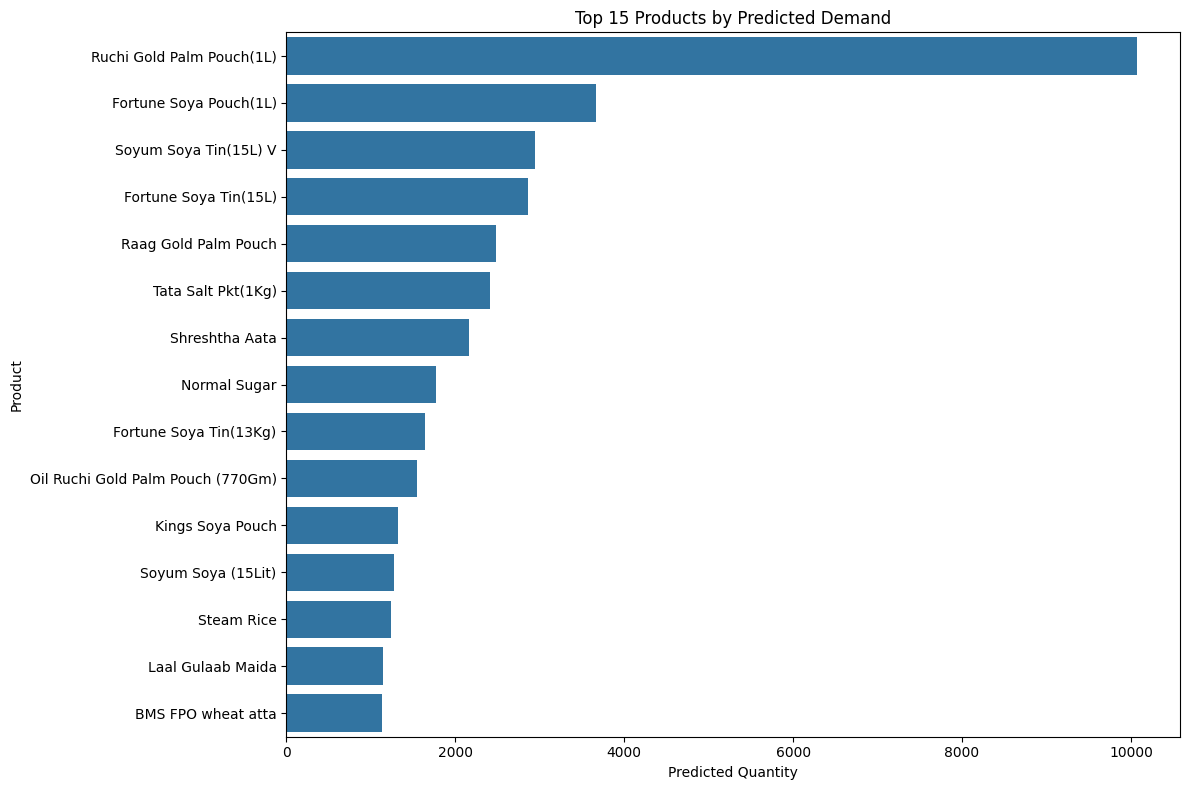

In [13]:
def aggregate_demand_by_product(predictions):
    """
    Aggregate demand by product for inventory planning
    """
    # Filter to rows with predicted orders
    ordered = predictions[predictions['will_order'] == 1]

    # Group by product
    product_demand = ordered.groupby('item_name').agg({
        'predicted_quantity': 'sum',
        'customer_id': 'nunique'
    }).reset_index()

    product_demand.columns = ['item_name', 'total_predicted_quantity', 'unique_customers']
    product_demand = product_demand.sort_values('total_predicted_quantity', ascending=False)

    print("\nTop products by predicted demand:")
    print(product_demand.head(10))

    # Visualize top products
    plt.figure(figsize=(12, 8))
    top_products = product_demand.head(15)
    sns.barplot(x='total_predicted_quantity', y='item_name', data=top_products)
    plt.title('Top 15 Products by Predicted Demand')
    plt.xlabel('Predicted Quantity')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()

    return product_demand

# Aggregate demand by product
product_demand = aggregate_demand_by_product(predictions)


In [14]:
def generate_customer_recommendations(predictions, top_n=5):
    """
    Generate top product recommendations for each customer
    """
    # Get customers with predictions
    customers = predictions['customer_id'].unique()

    all_recommendations = []

    for customer in customers:
        # Get customer's predictions
        customer_preds = predictions[predictions['customer_id'] == customer].copy()

        # Sort by selection probability
        customer_preds = customer_preds.sort_values('selection_probability', ascending=False)

        # Get top N recommendations
        top_recommendations = customer_preds.head(top_n)

        # Only include products with non-zero probability
        top_recommendations = top_recommendations[top_recommendations['selection_probability'] > 0]

        all_recommendations.append(top_recommendations)

    # Combine all recommendations
    if all_recommendations:
        recommendations_df = pd.concat(all_recommendations)

        print(f"\nGenerated recommendations for {len(customers)} customers")

        # Display sample recommendations for a few customers
        sample_customers = recommendations_df['customer_id'].unique()[:3]
        for customer in sample_customers:
            print(f"\nRecommendations for customer {customer}:")
            print(recommendations_df[recommendations_df['customer_id'] == customer])

        return recommendations_df
    else:
        print("No recommendations generated")
        return pd.DataFrame()

# Generate customer recommendations
customer_recommendations = generate_customer_recommendations(predictions)



Generated recommendations for 4161 customers

Recommendations for customer 1:
    customer_id                item_name  selection_probability  will_order  \
16            1  Om Mahakaaleshwar Maida               1.000000           1   
23            1           Shreshtha Aata               1.000000           1   
13            1    Laal Gulaab Suji/Rava               1.000000           1   
15            1   Om Mahakaaleshwar Aata               1.000000           1   
18            1            Prakash Maida               0.997509           1   

    predicted_quantity  
16                   1  
23                   4  
13                  24  
15                   2  
18                   2  

Recommendations for customer 4:
    customer_id                      item_name  selection_probability  \
29            4                  Prakash Maida               0.043520   
31            4      Ruchi Gold Palm Pouch(1L)               0.020862   
25            4  Bawarchi Vanaspati Pouch 1l

In [15]:
customer_recommendations.to_csv('customer_recommendations.csv', index=False)

Running forecast with cutoff date: 2025-03-27 00:00:00

Engineering features...

Preparing training data...
Preparing to predict orders from 2025-03-28 00:00:00 to 2025-04-10 00:00:00

Building prediction models...
Class distribution - Not ordered: 26339, Ordered: 4060
Using class weights: {0: 1, 1: np.float64(6.487438423645321)}

Product Selection Model Evaluation:
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      6585
         1.0       0.40      0.64      0.49      1015

    accuracy                           0.82      7600
   macro avg       0.67      0.75      0.69      7600
weighted avg       0.87      0.82      0.84      7600

ROC AUC: 0.8440

Top 5 important features:
                  feature  importance
15          reorder_score    0.228587
1   days_since_last_order    0.142458
0         order_frequency    0.127592
16       product_affinity    0.066225
2          total_quantity    0.049644

Quantity Prediction Model Evalua

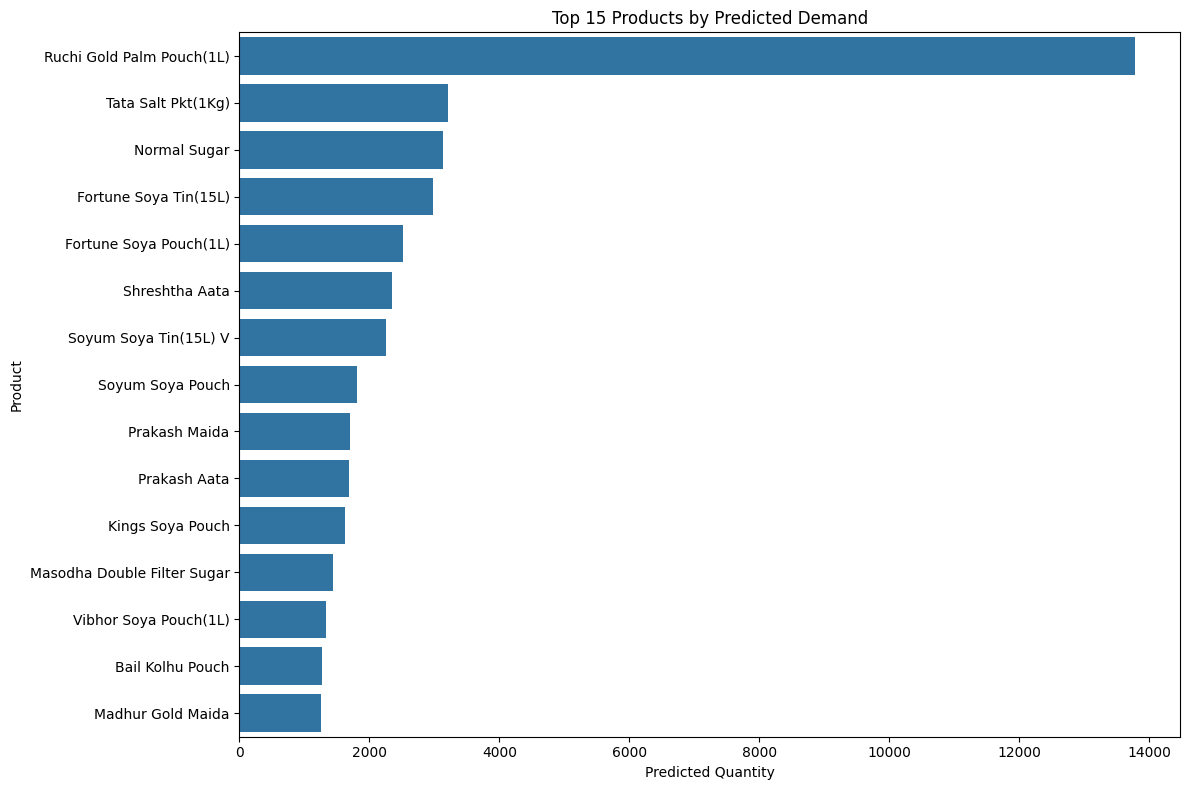


Generating customer recommendations...

Generated recommendations for 3964 customers

Recommendations for customer 1:
    customer_id              item_name  selection_probability  will_order  \
16            1          Prakash Maida               0.940033           1   
21            1         Shreshtha Aata               0.935469           1   
18            1      Pukhraj Arhar Dal               0.809865           1   
13            1  Laal Gulaab Suji/Rava               0.806086           1   
2             1                Arrarot               0.783766           1   

    predicted_quantity  
16                   2  
21                   2  
18                   2  
13                  18  
2                    2  

Recommendations for customer 4:
    customer_id                      item_name  selection_probability  \
29            4      Ruchi Gold Palm Pouch(1L)               0.707095   
27            4                  Prakash Maida               0.547655   
23            4 

In [16]:
def run_sku_forecasting_pipeline(df, cutoff_date=None, prediction_window=14):
    """
    Run the complete SKU-level demand forecasting pipeline
    """
    # If no cutoff date is provided, use the latest date in the dataset
    if cutoff_date is None:
        cutoff_date = df['order_date'].max() - pd.Timedelta(days=prediction_window)

    print(f"Running forecast with cutoff date: {cutoff_date}")

    # Only use data prior to cutoff date for training
    historical_data = df[df['order_date'] <= cutoff_date].copy()

    # Creating features
    print("\nEngineering features...")
    cp_features = create_customer_product_features(historical_data)
    features_with_customer = add_customer_features(historical_data, cp_features)
    complete_features = add_product_features(historical_data, features_with_customer)
    final_features = add_interaction_features(complete_features)

    # Prepare training data
    print("\nPreparing training data...")
    training_data, feature_cols = prepare_training_data(df, final_features, cutoff_date, prediction_window)

    # Build models
    print("\nBuilding prediction models...")
    selection_model, selection_scaler = build_product_selection_model(training_data, feature_cols)
    quantity_model, quantity_scaler = build_quantity_prediction_model(training_data, feature_cols)

    # Make predictions
    print("\nMaking predictions...")
    predictions = predict_future_orders(
        final_features, selection_model, quantity_model,
        selection_scaler, quantity_scaler, feature_cols
    )

    # Aggregate demand for inventory planning
    print("\nAggregating demand for inventory planning...")
    product_demand = aggregate_demand_by_product(predictions)

    # Generate customer recommendations
    print("\nGenerating customer recommendations...")
    customer_recommendations = generate_customer_recommendations(predictions)

    return {
        'predictions': predictions,
        'product_demand': product_demand,
        'customer_recommendations': customer_recommendations,
        'models': {
            'selection_model': selection_model,
            'quantity_model': quantity_model,
            'selection_scaler': selection_scaler,
            'quantity_scaler': quantity_scaler
        }
    }


results = run_sku_forecasting_pipeline(merged)


In [17]:
def calculate_inventory_requirements(predictions_df, product_demand_df, current_stock_df=None):
    """
    Calculate inventory requirements for next 14 days.
    """
    # Generate future date range
    start_date = pd.to_datetime("2025-04-15")  # Use current date from context
    date_range = pd.date_range(start=start_date, periods=14, name='order_date')

    # Create full product-date grid
    products = predictions_df['item_name'].unique()
    full_grid = pd.MultiIndex.from_product([products, date_range], names=['item_name', 'order_date']).to_frame(index=False)

    # Merge predictions with date grid
    predictions_df = full_grid.merge(predictions_df, on=['item_name'], how='left')
    predictions_df['predicted_quantity'] = predictions_df['predicted_quantity'].fillna(0)

    # Rest of original logic remains unchanged
    daily_demand = predictions_df.groupby(['item_name', 'order_date'])['predicted_quantity'].sum().unstack().fillna(0)

    projection = daily_demand.sum(axis=1).to_frame(name='14_day_demand')

    if current_stock_df is not None:
        projection = projection.merge(current_stock_df,
                                     left_index=True,
                                     right_on='item_name',
                                     how='left')
        projection['current_stock'] = projection['current_stock'].fillna(0)
    else:
        projection['current_stock'] = 0

    projection['safety_stock'] = (projection['14_day_demand'] * 0.2).round().astype(int) + 10

    projection['recommended_order'] = np.where(
        projection['current_stock'] < projection['14_day_demand'] + projection['safety_stock'],
        (projection['14_day_demand'] + projection['safety_stock'] - projection['current_stock']).clip(lower=0),
        0
    )

    return projection.reset_index()[['item_name', '14_day_demand',
                                    'current_stock', 'safety_stock',
                                    'recommended_order']]

In [20]:
# Example: current_stock is a DataFrame with columns ['item_name', 'current_stock']
inventory_plan = calculate_inventory_requirements(
    predictions_df=predictions[predictions['will_order'] == 1][['item_name', 'predicted_quantity']],
    product_demand_df=None,  # Not needed if using predictions directly

)

In [21]:
print(inventory_plan.head(10))  # Shows the top 10 products needing replenishment


                      item_name  14_day_demand  current_stock  safety_stock  \
0                   7 Star Rice           1106              0           231   
1            AJMAL BASMATI RICE            322              0            74   
2  ASHOK BIRYANI MASALA (50 GM)            280              0            66   
3  Aashirwad Chakki Atta (10kg)           5446              0          1099   
4   Aashirwad Chakki Atta (5kg)           5474              0          1105   
5              Adani Mota Besan            994              0           209   
6             Adani Patla Besan            560              0           122   
7                 Agni Tata Tea           1456              0           301   
8        Agro Chana Besan Mahin             14              0            13   
9         Agro Chana Besan Mota             56              0            21   

   recommended_order  
0               1337  
1                396  
2                346  
3               6545  
4              

In [22]:
inventory_plan.to_csv('inventory_plan.csv', index=False)